# Classification Analysis

In [134]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, make_scorer
from xgboost import XGBClassifier

def fb_score(y_true, y_pred, beta):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    return ((1 + beta**2) * precision * recall) / ((beta**2) * precision + recall)

def f1_func(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    return (2 * precision * recall) / (precision + recall)

def f2_func(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    return (5 * precision * recall) / (4 * precision + recall)

def classification_results(y_true, y_pred, verbose=0):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_func(y_true, y_pred)
    f2 = f2_func(y_true, y_pred)
    results = [
        ("accuracy", accuracy), 
        ("precision", precision),
        ("recall", recall),
        ("f1", f1),
        ("f2", f2),
    ]
    if verbose:
        print("\nCLASSIFICATION METRICS:\n")
        for (metric, score) in results:
            print(f"{metric} = {score:.2f}")
        print("\n")
    return results

f1_score = make_scorer(f1_func)
f2_score = make_scorer(f2_func)

base_dir = os.path.join(os.getcwd(), os.pardir)

Get the data.

In [55]:
data_path = os.path.join(base_dir, "data/altered/imputed/maps_xgboost_impute.csv")
df = pd.read_csv(data_path, index_col="X")
df

,comp_bed_9,mat_dep,mat_age,weight_16,height_16,iq,comp_noint_bed_16,comp_int_bed_16,talk_phon_wend,text_wend,...,dep_score,comp_house,tv_bed_16,creat_14,comp_games,fam_tv_eve,fam_tv_aft,fam_tv_mor,sex,birth_order
X,,,,,,,,,,,,,,,,,,,,,
1,0.0,3.000000,30.0,59.294132,181.602831,107.000000,0.0,1.0,1.0,1.0,...,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0
2,0.0,9.000000,26.0,32.752800,139.659500,85.000000,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,3.000000,24.0,32.667496,139.719131,45.272793,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,1.0,0.0
4,0.0,0.000025,22.0,49.812426,160.224186,45.179386,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5,0.0,8.000000,31.0,62.270030,191.703227,132.000000,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,2.0,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13730,0.0,13.000000,27.0,32.788525,139.712128,45.198166,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,0.0,0.0
13731,0.0,6.000000,29.0,32.708584,139.544815,45.110069,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0
13732,0.0,21.000000,37.0,58.075832,169.235565,108.000000,0.0,1.0,1.0,2.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


For the test set we do not want to use imputed data.

In [215]:
orig_path = os.path.join(base_dir, "data/altered/maps_feature_mapping.csv")
orig_df = pd.read_csv(orig_path, index_col="X")

Create train and test sets. 

In [69]:
X = df.drop("has_dep_diag", axis=1)
y = df["has_dep_diag"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

`Note: we use the straify parameter to maintain the target class balance between testing and training sets.`

## Feature sets

Because a lot of the features in the dataset are highly correlated with eachother it makes sense to create some feature-sets so we can make analysis with or without certain groups of features.

As we are looking to see if increased screen time leads to poorer mental health, it does not make sense to make clasifications of `has_dep_diag` from all the features as this includes features such as `dep_score`, `dep_band`, `dep_thoughts` etc. which will contribute to the classification far more than screen time related features such as `comp_house` and `comp_games`.

We shall create feature sets for:

- __all__ features
- __non-medical__ features (depression, anxiety etc.)
- __only screen time__ features

In [201]:
all_features = X.columns

medical_features = [
    "mat_dep","mat_anx_1", "mat_anx_18m", 
    "mat_anx_8m", "agg_score", "emot_cruel", 
    "phys_cruel", "mat_anx_0m", "dep_band_15", 
    "dep_band_13", "dep_band_10", "dep_band_07", 
    "anx_band_15", "anx_band_13", "anx_band_10", 
    "anx_band_07", "secd_diag","prim_diag", 
    "panic_score", "dep_thoughts", "dep_score", 
]

# [feature for feature in all_features if not feature in medical_features]
non_medical_features = [
    "comp_bed_9", "mat_age", "weight_16", "height_16", "iq",
    "comp_noint_bed_16", "comp_int_bed_16", "talk_phon_wend", 
    "text_wend", "talk_mob_wend", "comp_wend", "musi_wend", 
    "read_wend", "work_wend", "alon_wend", "draw_wend", 
    "play_wend", "tv_wend", "out_win_wend", "out_sum_wend", 
    "tran_wend", "talk_phon_week", "text_week", "talk_mob_week", 
    "comp_week", "musi_week", "read_week", "work_week", 
    "alon_week", "draw_week", "play_week", "tv_week", 
    "out_win_week", "out_sum_week", "tran_week", "pat_pres_10", 
    "pat_pres_8", "pat_pres", "num_home", "pat_ses", "mat_ses", 
    "pat_edu", "mat_edu", "parity", "exercise", "child_bull", 
    "phone_14_wend", "phone_14_week", "musi_13", "tv_bed_9", 
    "own_mob", "comp_house", "tv_bed_16", "creat_14", "comp_games", 
    "fam_tv_eve", "fam_tv_aft", "fam_tv_mor", "sex", "birth_order"
]

screen_time_features = [
    "comp_bed_9", "comp_noint_bed_16", 
    "comp_int_bed_16", "comp_wend", "tv_wend",
    "comp_week", "tv_week", "tv_bed_9", 
    "comp_house", "tv_bed_16", "comp_games", 
    "fam_tv_eve", "fam_tv_aft", "fam_tv_mor",
]

fset_cols = [all_features, non_medical_features, screen_time_features]

`note: we consider 'screen time' to be features relating to either a computer or TV.`

We can now create the reduced training and testing sets.

In [202]:
X_train_all = X_train[all_features]
X_test_all = X_test[all_features]

X_train_non_medical = X_train[non_medical_features]
X_test_non_medical = X_test[non_medical_features]

X_train_screen_time = X_train[screen_time_features]
X_test_screen_time = X_test[screen_time_features]

fsets = [
    ("all features", X_train_all, X_test_all),
    ("non medical features", X_train_non_medical, X_test_non_medical),
    ("screen time features", X_train_screen_time, X_test_screen_time),
]

## Class balance

We wish to perform classification on the feature `has_dep_diag`. Our evaluation metric of choice will depend on the balance of positive and negative samples. Let's look at the count of each.

<AxesSubplot:xlabel='class', ylabel='count'>

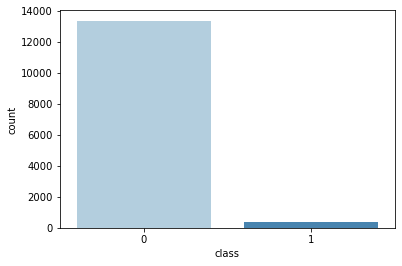

In [39]:
dep_counts = df["has_dep_diag"].value_counts()
dep_list = list(zip([0, 1], dep_counts.tolist()))

dep_df = pd.DataFrame(dep_list, columns=["class", "count"])

sns.barplot(x="class", y="count", data=dep_df, palette="Blues")

As you can see the distribution of values in this feature is massively uneven.

This is not ideal from a classification perspective, but we wouldn't really want half of the children in the study to be depressed!

Lets also get the exact ratio as this will be useful later. We call the positive class (1) the minority class and the negative class (0) the majority class.

In [51]:
sample_ratio = dep_counts[0] / dep_counts[1]

print(f"minority:majority = {dep_counts[1]}:{dep_counts[0]} (1:{sample_ratio:.0f})")

minority:majority = 389:13345 (1:34)


## Metrics for imbalanced classification

When analysing the performance of classification on the imputated data we used F1-score as our target metric. We did so as we suspected we would have imbalanced classes and so standard accuracy would not perform well. F1-score is the harmonic mean of precision and recall, so maximising the F1-score results in a classifier sensitive to both true positives and false negatives.

F1-score is an instance of the more general metric F-score, or Fβ. The equation for Fβ is as follows:

```
Fβ = ((1 + β^2) * precision * recall) / ((β**2) * precision + recall)
```

With F1 we have:

```
F1 = ((1 + 1) * precision * recall) / (1 * precision + recall)
F1 = (2 * precision * recall) / precision + recall)
```

It then follows that the F2 score would be: 

```
F2 = (1 + 4) * precision * recall) / ((4) * precision + recall)
F2 = (5 * precision * recall) / (4 * precision + recall)
```

This results in a metric which weights recall higher than precision. What this means is we have a metric that is sensitive to false negatives.

False negative sensitivity is of particular interest to us as we would rather air on the side of caution and mis-classify someone as having depression and them receive treatment than classify someone who didn't as being ok. For this reason we shall use the F2 score as our target metric for further classification analysis.

## Classification optimisation

Our previous classifier was not optimal. We shall run a randomised hyper-parameter search to find a better classifier.

First lets create the base classifier.

In [73]:
xgb = XGBClassifier(
	objective="binary:logistic",
    eval_metric="logloss",
	scale_pos_weight=sample_ratio,
	n_jobs=1,
)

`Note: we have used the sample ratio to tell XGBoost to weight the positive and negative samples correctly.`

Let's specify the search parameters.

In [68]:
params = {
	"n_estimators": [200, 500, 1000],
	"max_depth": [3, 5, 10],
	"gamma": [0.5, 1, 2],
	"min_child_weight": [1, 5, 10],
	"subsample": [0.5, 0.75, 1],
	"colsample_bytree": [0.5, 0.75, 1],
}

We shall also specify the scoring metrics.

In [74]:
scoring = [accuracy_score, precision_score, recall_score, f1_score, f2_score]

Now we can perform a search of 20 parameter permutations with 3-fold cross-validation.

In [109]:
rsearch = RandomizedSearchCV(xgb, params, scoring=f2_score, n_iter=20, cv=3, n_jobs=-1)

Now we can run the parameter search.

As we discovered during imputation analysis, classification with all features yields results nearing 100% accuracy (and 1.0 F1-score). 

This will make it difficult to compare parameter due to perfect accuracy being easily obtainable. It makes sense to use the most reduced feature set as the increased difficulty of the classification task will require more precise parameter choices. As the screen time features are the target of our main analysis it also makes sense to optimse our classifier for this task.

In [110]:
rsearch.fit(X_train_screen_time, y_train)

/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[11:21:48] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:21:51] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was c

RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                                           random_state=None, reg_alpha=None,
                                           reg_lambda=None,
                                           

Now we can look at the best parameters.

In [111]:
rsearch.best_score_

0.16078931988022896

In [112]:
rsearch.best_params_

{'subsample': 1,
 'n_estimators': 200,
 'min_child_weight': 10,
 'max_depth': 3,
 'gamma': 2,
 'colsample_bytree': 1}

`Note: as we used a random parameter search this is likely not the best results, but due to the time-complexity of using a grid search with this parameter set this shall suffice.`

Let's test the accuracy on the test set.

In [136]:
best_xgb = rsearch.best_estimator_

preds = best_xgb.predict(X_test_screen_time)
results = classification_results(y_test, preds, verbose=1)


CLASSIFICATION METRICS:

accuracy = 0.74
precision = 0.04
recall = 0.35
f1 = 0.07
f2 = 0.13




Let's compare this to the base XGBoost classifier to check we made some improvement.

In [147]:
clf = XGBClassifier(
	objective="binary:logistic",
    eval_metric="logloss",
	scale_pos_weight=sample_ratio,
	n_jobs=-1,
)

clf.fit(X_train_screen_time, y_train)
preds = clf.predict(X_test_screen_time)

clf_results = classification_results(y_test, preds, verbose=1)

/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

CLASSIFICATION METRICS:

accuracy = 0.86
precision = 0.03
recall = 0.14
f1 = 0.06
f2 = 0.09




Accuracy may have reduced, but as explained previously this is somewhat meaningless when we have unabalanced classes.

The important metric here is F2 score and this increased from `0.09` to `0.13`.

## Classification on feature sets

We shall perform classification on each of the feature sets.

In [213]:
fset_results = []

for (fset, fset_X_train, fset_X_test) in fsets:
    xgb = XGBClassifier(
	    objective="binary:logistic",
        eval_metric="logloss",
	    scale_pos_weight=sample_ratio,
        subsample=1,
        n_estimators=200,
        min_child_weight=10,
        max_depth=3,
        gamma=2,
        colsample_bytree=1,
	    n_jobs=-1,
    )
    xgb.fit(fset_X_train, y_train)
    preds = xgb.predict(fset_X_test)
    results = classification_results(y_test, preds)
    fset_results.append((fset, xgb, results))

/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Classification results of each feature set.

In [214]:
fset_results

[('all features',
  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
                gamma=2, gpu_id=-1, importance_type='gain',
                interaction_constraints='', learning_rate=0.300000012,
                max_delta_step=0, max_depth=3, min_child_weight=10, missing=nan,
                monotone_constraints='()', n_estimators=200, n_jobs=-1,
                num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
                scale_pos_weight=34.30591259640103, subsample=1,
                tree_method='exact', validate_parameters=1, verbosity=None),
  [('accuracy', 1.0),
   ('precision', 1.0),
   ('recall', 1.0),
   ('f1', 1.0),
   ('f2', 1.0)]),
 ('non medical features',
  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
                gamma=2, gpu_id=-1, importance_type

Importances of each feature set.

In [197]:
for (features, (fset, fset_xgb, fset_result)) in zip(fset_cols, fset_results):

    fset_importances = [(feature, importance) for (feature, importance) in zip(features, fset_xgb.feature_importances_)]
    fset_imp_df = pd.DataFrame(fset_importances, columns=["feature", "importance"])

    print(fset, fset_imp_df, "\n")

all features         feature  importance
0    comp_bed_9         0.0
1       mat_dep         0.0
2       mat_age         0.0
3     weight_16         0.0
4     height_16         0.0
..          ...         ...
76   fam_tv_eve         0.0
77   fam_tv_aft         0.0
78   fam_tv_mor         0.0
79          sex         0.0
80  birth_order         0.0

[81 rows x 2 columns] 

non medical features               feature  importance
0          comp_bed_9    0.008134
1             mat_age    0.016937
2           weight_16    0.026406
3           height_16    0.019345
4                  iq    0.019781
5   comp_noint_bed_16    0.011377
6     comp_int_bed_16    0.000000
7      talk_phon_wend    0.000000
8           text_wend    0.017911
9       talk_mob_wend    0.014920
10          comp_wend    0.004834
11          musi_wend    0.013756
12          read_wend    0.013357
13          work_wend    0.017222
14          alon_wend    0.018307
15          draw_wend    0.011598
16          play_wend    0.

Plot importances.

In [149]:
# barplot